In [1]:
# %pip install xgboost shap rpy2 linearmodels


In [2]:
# Imports

import os
import re
import pandas as pd
import numpy as np


from sklearn.linear_model import LinearRegression


## Load Data

In [4]:
# Root data Directory
# Base path
base_root = '../data/raw'

file_paths = {
    'capital': os.path.join(base_root, 'CapitalStockData.csv'),
    'energy': os.path.join(base_root, 'energy_use.csv'),
    'labor_force': os.path.join(base_root, 'labor_force.csv'),
    'patents': os.path.join(base_root, 'patents_res_nonres.csv'),
    'rnd': os.path.join(base_root, 'R&D.csv'),
    'unemployment': os.path.join(base_root, 'unemployed_ilo_estimate.csv'),
    'population': os.path.join(base_root, 'population_Data.csv'),
    'human_capital' : os.path.join(base_root, 'Human_Capital_Data.csv'),
}

In [5]:
dfs = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Assign each DataFrame to a variable with _df suffix
for name, df in dfs.items():
    globals()[f"{name}_df"] = df

# Print heads 
for name in dfs.keys():
    print(f"{name}_df")
    # print(globals()[f"{name}_df"].head())
    # print("\n" + "-"*60 + "\n")



capital_df
energy_df
labor_force_df
patents_df
rnd_df
unemployment_df
population_df
human_capital_df


## Wrangle Data

In [7]:
def process_time_series(
    df: pd.DataFrame,
    id_vars_map: dict,
    year_col: str = 'year',
    cutoff_year: int = 2019,
    drop_id_na_all: bool = True,
    value_name: str = 'value'
):
    # 0a) Rename ID cols + strip "[YR####]" suffixes
    df2 = df.rename(columns=id_vars_map).copy()
    yr_pat = re.compile(r'^(\d{4}) \[YR\d{4}\]$')
    strip  = {c: yr_pat.match(c).group(1)
              for c in df2.columns if yr_pat.match(c)}
    if strip:
        df2 = df2.rename(columns=strip)

    # 1) static IDs
    id_vars = list(id_vars_map.values())

    # 2) Melt → long
    if year_col in df2.columns:
        ivy        = id_vars + [year_col]
        value_vars = [c for c in df2.columns if c not in ivy]
        df_long    = df2.melt(
            id_vars    = ivy,
            value_vars = value_vars,
            var_name   = 'series',
            value_name = value_name
        )
        df_long[year_col] = df_long[year_col].astype(int)
    else:
        year_cols = [c for c in df2.columns if c not in id_vars]
        df_long   = df2.melt(
            id_vars    = id_vars,
            value_vars = year_cols,
            var_name   = year_col,
            value_name = value_name
        )
        df_long[year_col] = df_long[year_col].astype(int)

    # 3) coerce & cutoff
    df_long[value_name] = pd.to_numeric(df_long[value_name], errors='coerce')
    df_long            = df_long[df_long[year_col] <= cutoff_year]

    # 4) drop rows where ALL IDs+year are missing
    if drop_id_na_all:
        df_long = df_long.dropna(subset=id_vars + [year_col], how='all')

    # 5) track missing before
    df_long['_missing_before'] = df_long[value_name].isna()

    # 6) interpolate per group
    if 'series' in df_long:
        group_cols = id_vars + ['series']
        metric_col = 'series'
    else:
        group_cols = id_vars
        metric_col = id_vars[0]
    df_long = df_long.sort_values(group_cols + [year_col])
    df_long[value_name] = (
        df_long
        .groupby(group_cols)[value_name]
        .transform(lambda s: s.interpolate('linear').ffill().bfill())
    )

    # 7) track imputed + leftover
    df_long['_imputed']       = df_long['_missing_before'] & df_long[value_name].notna()
    df_long['_missing_after'] = df_long[value_name].isna()

    # 8) summary
    summary = (
        df_long
        .groupby(metric_col)
        .agg(
            total           =(value_name,      'size'),
            missing_before  =('_missing_before','sum'),
            imputed         =('_imputed',      'sum'),
            missing_after   =('_missing_after','sum'),
        )
        .assign(
            missing_before_pct=lambda d: d['missing_before']/d['total']*100,
            imputed_pct       =lambda d: d['imputed']/d['total']*100,
            missing_after_pct =lambda d: d['missing_after']/d['total']*100,
        )
        .reset_index()
    )
    return df_long, summary



In [8]:
capital_df

,countrycode,ifscode,countryname,year,igov_rppp,kgov_rppp,ipriv_rppp,kpriv_rppp,ippp_rppp,kppp_rppp,GDP_rppp,igov_n,kgov_n,ipriv_n,kpriv_n,kppp_n,GDP_n,income
0,AFG,512,Afghanistan,1960,3.0,50.0,1.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Income Developing Countries
1,AFG,512,Afghanistan,1961,3.0,52.0,1.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Income Developing Countries
2,AFG,512,Afghanistan,1962,4.0,54.0,1.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Income Developing Countries
3,AFG,512,Afghanistan,1963,4.0,56.0,1.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Income Developing Countries
4,AFG,512,Afghanistan,1964,4.0,59.0,1.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Income Developing Countries
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11635,ZWE,698,Zimbabwe,2015,NaN,NaN,NaN,NaN,0.0,0.0,42.0,NaN,NaN,NaN,NaN,0.0,20.0,Low Income Developing Countries
11636,ZWE,698,Zimbabwe,2016,NaN,NaN,NaN,NaN,0.0,0.0,42.0,NaN,NaN,NaN,NaN,0.0,21.0,Low Income Developing Countries
11637,ZWE,698,Zimbabwe,2017,NaN,NaN,NaN,NaN,0.0,0.0,44.0,NaN,NaN,NaN,NaN,0.0,22.0,Low Income Developing Countries
11638,ZWE,698,Zimbabwe,2018,NaN,NaN,NaN,NaN,0.0,0.0,46.0,NaN,NaN,NaN,NaN,0.0,24.0,Low Income Developing Countries


In [9]:
# Rename the raw DF
capital_df = capital_df.rename(columns={
    'countryname': 'country',
    'countrycode': 'country_code',
    'income':      'income_group'
})

# count before dropping missing-target
print("Rows before dropping missing GDP_rppp:", len(capital_df))

# Drop any rows where our target GDP_rppp is NaN
capital_df = capital_df[capital_df['GDP_rppp'].notna()].copy()

# count after
print("Rows after dropping missing GDP_rppp: ", len(capital_df))

# Now include income in your static IDs so it is *not* melted as a series
cap_map = {
    'countrycode': 'country_code',   
    'ifscode':     'ifscode',
    'country':     'country',
    'income':      'income_group'
}

cap_long, cap_summary = process_time_series(
    capital_df,
    id_vars_map = cap_map,
    year_col    = 'year',
    cutoff_year = 2019   # we have target variable only up to 2019
)

# pivot back if you like:
capital_df_processed = (
    cap_long
    .pivot_table(
        index   = list(cap_map.values()) + ['year'],
        columns = 'series',
        values  = 'value'
    )
    .reset_index()
)

print("\nAfter imputation summary:")
print(cap_summary)



Rows before dropping missing GDP_rppp: 11640
Rows after dropping missing GDP_rppp:  10284

After imputation summary:
        series  total  missing_before  imputed  missing_after  \
0        GDP_n  10284               0        0              0   
1     GDP_rppp  10284               0        0              0   
2       igov_n  10284            2332     1362            970   
3    igov_rppp  10284            1060       90            970   
4    ippp_rppp  10284            5499     2819           2680   
5      ipriv_n  10284            2332     1362            970   
6   ipriv_rppp  10284            1060       90            970   
7       kgov_n  10284            2121     1361            760   
8    kgov_rppp  10284             839       79            760   
9       kppp_n  10284            5569     2789           2780   
10   kppp_rppp  10284            5569     2789           2780   
11     kpriv_n  10284            2121     1361            760   
12  kpriv_rppp  10284             839 

In [10]:
# print("energy_df:", energy_df.columns.tolist())
# print("labor_force_df:", labor_force_df.columns.tolist())
# print("patents_df:", patents_df.columns.tolist())
# print("rnd_df:", rnd_df.columns.tolist())
# print("unemployment_df:", unemployment_df.columns.tolist())
# print("population_df:", population_df.columns.tolist())


In [11]:
#  Assemble all seven datasets into a dict

wb_map = {
  'Series Name':  'series_name',
  'Series Code':  'series_code',
  'Country Name': 'country',
 #  'Country Code': 'country_code',
 #  'countrycode':  'country_code'
 }
# Bundle raw WB‐style tables
wb_dfs = {
  'energy':         energy_df,
  'labor_force':    labor_force_df,
  'patents':        patents_df,
  'rnd':            rnd_df,
  'unemployment':   unemployment_df,
  'population':     population_df,
  'human_capital':  human_capital_df,
}


In [12]:
# Pre‐clean each DF: unify & drop any countrycode variants

cleaned = {}
for name, df in wb_dfs.items():
    df2 = df.copy()
    # if there's a 'Country Code' or 'countrycode' column, drop it:
    for col in ['Country Code','countrycode']:
        if col in df2.columns:
            df2 = df2.drop(columns=[col])
    cleaned[name] = df2


In [13]:
# Process all of them exactly as before
processed = {}
summaries = {}
for name, df in cleaned.items():
    long_filled, summary = process_time_series(
        df,
        id_vars_map = wb_map,
        year_col    = 'year',
        cutoff_year = 2019
    )
    processed[name]  = long_filled
    summaries[name]  = summary


In [14]:
for name, df in processed.items():
    print(f"\nNaN counts for: {name}")
    print(df.isna().sum())
    print("-" * 60)



NaN counts for: energy
series_name           0
series_code           0
country               0
year                  0
value              2760
_missing_before       0
_imputed              0
_missing_after        0
dtype: int64
------------------------------------------------------------

NaN counts for: labor_force
series_name           0
series_code           0
country               0
year                  0
value              1860
_missing_before       0
_imputed              0
_missing_after        0
dtype: int64
------------------------------------------------------------

NaN counts for: patents
series_name            0
series_code            0
country                0
year                   0
value              10980
_missing_before        0
_imputed               0
_missing_after         0
dtype: int64
------------------------------------------------------------

NaN counts for: rnd
series_name           0
series_code           0
country               0
year                  0

In [15]:
# 1) Define which ID columns must be present
id_cols = ['series_name','series_code','country']

processed_clean = {}
for name, long_df in processed.items():
    # 2) Drop rows where ALL of series_name, series_code, country are NaN
    df_clean = long_df.dropna(subset=id_cols, how='all')
    processed_clean[name] = df_clean

    # 3) Pivot back to wide by country + year
    #    (one column per unique series_name)
    wide = (
        df_clean
        .pivot_table(
            index=['country','year'],
            columns='series_name',
            values='value'
        )
        .reset_index()
    )
    # flatten the columns
    wide.columns.name = None
    wide.columns = [str(c) for c in wide.columns]

    # 4) assign to a new variable
    globals()[f"{name}_df_processed"] = wide

# Now we have:
#   energy_df_processed, labor_force_df_processed, …


In [16]:
print("energy_df_processed:")
print(energy_df_processed.head())
print("-" * 60)

print("labor_force_df_processed:")
print(labor_force_df_processed.head())
print("-" * 60)

print("patents_df_processed:")
print(patents_df_processed.head())
print("-" * 60)

print("rnd_df_processed:")
print(rnd_df_processed.head())
print("-" * 60)

print("unemployment_df_processed:")
print(unemployment_df_processed.head())
print("-" * 60)

print("population_df_processed:")
print(population_df_processed.head())
print("-" * 60)

print("human_capital_df_processed:")
print(human_capital_df_processed.head())
print("-" * 60)

energy_df_processed:
                       country  year  \
0  Africa Eastern and Southern  1960   
1  Africa Eastern and Southern  1961   
2  Africa Eastern and Southern  1962   
3  Africa Eastern and Southern  1963   
4  Africa Eastern and Southern  1964   

   Energy use (kg of oil equivalent per capita)  
0                                    784.540725  
1                                    784.540725  
2                                    784.540725  
3                                    784.540725  
4                                    784.540725  
------------------------------------------------------------
labor_force_df_processed:
       country  year  Labor force, total
0  Afghanistan  1960           2978278.0
1  Afghanistan  1961           2978278.0
2  Afghanistan  1962           2978278.0
3  Afghanistan  1963           2978278.0
4  Afghanistan  1964           2978278.0
------------------------------------------------------------
patents_df_processed:
   country  year  Pate

In [17]:
# Collect  all processed‐wide tables into a dict
wide_dfs = {
    'capital':        capital_df_processed,
    'energy':         energy_df_processed,
    'labor_force':    labor_force_df_processed,
    'patents':        patents_df_processed,
    'rnd':            rnd_df_processed,
    'unemployment':   unemployment_df_processed,
    'population':     population_df_processed,
    'human_capital':  human_capital_df_processed,
}

# Loop & print missing‐counts + missing‐% for each
for name, df in wide_dfs.items():
    missing_count = df.isna().sum()
    missing_pct   = df.isna().mean() * 100

    print(f"\n=== Missing values in {name.replace('_',' ').title()} ===")
    report = pd.DataFrame({
        'missing_count': missing_count,
        'missing_pct':   missing_pct.round(2)
    })
    print(report)



=== Missing values in Capital ===
              missing_count  missing_pct
series                                  
country_code              0         0.00
ifscode                   0         0.00
country                   0         0.00
income_group              0         0.00
year                      0         0.00
GDP_n                     0         0.00
GDP_rppp                  0         0.00
igov_n                  970         9.43
igov_rppp               970         9.43
ippp_rppp              2680        26.06
ipriv_n                 970         9.43
ipriv_rppp              970         9.43
kgov_n                  760         7.39
kgov_rppp               760         7.39
kppp_n                 2780        27.03
kppp_rppp              2780        27.03
kpriv_n                 760         7.39
kpriv_rppp              760         7.39

=== Missing values in Energy ===
                                              missing_count  missing_pct
country                               

In [18]:
# 1) List out your processed‐wide DataFrames in the order you want to merge them
to_merge = [
    population_df_processed,
    human_capital_df_processed,
    labor_force_df_processed,
    unemployment_df_processed,
    rnd_df_processed,
    patents_df_processed,
    energy_df_processed
]

# 2) Start from a copy of capital_df_processed
merged_data = capital_df_processed.copy()

# 3) Sequentially outer-merge each table on country + year
for df in to_merge:
    merged_data = merged_data.merge(
        df,
        on = ['country','year'],
        how = 'outer'
    )

# 4) Inspect the result
print("Final merged shape:", merged_data.shape)
merged_data.head(30)


Final merged shape: (16931, 50)


,country_code,ifscode,country,income_group,year,GDP_n,GDP_rppp,igov_n,igov_rppp,ippp_rppp,...,Urban population growth (annual %),Human capital index (HCI) (scale 0-1),"Labor force, total_x","Unemployment, total (% of total labor force) (modeled ILO estimate)_x","Labor force, total_y","Unemployment, total (% of total labor force) (modeled ILO estimate)_y",Researchers in R&D (per million people),"Patent applications, nonresidents","Patent applications, residents",Energy use (kg of oil equivalent per capita)
0,NaN,NaN,Afghanistan,NaN,1960,NaN,NaN,NaN,NaN,NaN,...,5.275389,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
1,NaN,NaN,Afghanistan,NaN,1961,NaN,NaN,NaN,NaN,NaN,...,5.275389,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
2,NaN,NaN,Afghanistan,NaN,1962,NaN,NaN,NaN,NaN,NaN,...,5.351671,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
3,NaN,NaN,Afghanistan,NaN,1963,NaN,NaN,NaN,NaN,NaN,...,5.392848,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
4,NaN,NaN,Afghanistan,NaN,1964,NaN,NaN,NaN,NaN,NaN,...,5.448598,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
5,NaN,NaN,Afghanistan,NaN,1965,NaN,NaN,NaN,NaN,NaN,...,5.497136,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
6,NaN,NaN,Afghanistan,NaN,1966,NaN,NaN,NaN,NaN,NaN,...,5.537563,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
7,NaN,NaN,Afghanistan,NaN,1967,NaN,NaN,NaN,NaN,NaN,...,5.546900,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
8,NaN,NaN,Afghanistan,NaN,1968,NaN,NaN,NaN,NaN,NaN,...,5.599994,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN
9,NaN,NaN,Afghanistan,NaN,1969,NaN,NaN,NaN,NaN,NaN,...,5.610218,0.389,2978278.0,8.07,2978278.0,8.07,NaN,NaN,NaN,NaN


In [19]:
# 1) Drop rows missing any of the essential metrics
merged_data = merged_data.dropna(
    subset=['GDP_rppp','kgov_rppp','kpriv_rppp'],
    how='all'
).reset_index(drop=True)

print("Shape after dropping rows with no GDP_rppp or kgov_rppp or kpriv_rppp:",
      merged_data.shape)

# 2) Identify all the metrics you want to count on
metric_cols = [
    c for c in merged_data.columns
    if c not in ['country','country_code','year']
]

# 3) Recompute missing & zero counts per country & country_code
records = []
for (country, code), group in merged_data.groupby(['country','country_code']):
    periods       = len(group)
    total_cells   = periods * len(metric_cols)
    missing_cells = int(group[metric_cols].isna().sum().sum())
    zero_cells    = int((group[metric_cols] == 0).sum().sum())
    records.append({
        'country':      country,
        'country_code': code,
        'periods':      periods,
        'total_cells':  total_cells,
        'missing_cells':missing_cells,
        'zero_cells':   zero_cells,
        'missing_pct':  missing_cells/total_cells*100 if total_cells else 0,
        'zero_pct':     zero_cells/total_cells*100 if total_cells else 0,
    })

summary_by_country = pd.DataFrame(records)
print(summary_by_country.sort_values('missing_pct', ascending=False))



Shape after dropping rows with no GDP_rppp or kgov_rppp or kpriv_rppp: (10284, 50)
                      country country_code  periods  total_cells  \
111                Micronesia          FSM       50         2350   
167  Taiwan Province of China          TWN       60         2820   
73              Hong Kong SAR          HKG       60         2820   
100                 Macao SAR          MAC       50         2350   
89                      Korea          KOR       60         2820   
..                        ...          ...      ...          ...   
65                     Greece          GRC       60         2820   
126           North Macedonia          MKD       30         1410   
125                   Nigeria          NGA       60         2820   
67                  Guatemala          GTM       60         2820   
192                  Zimbabwe          ZWE       60         2820   

     missing_cells  zero_cells  missing_pct   zero_pct  
111           2150         100    91.489362

In [20]:
# 1) Identify which countries to drop
mask = (
    (summary_by_country['missing_pct'] > 70) |
    ((summary_by_country['missing_pct'] + summary_by_country['zero_pct']) > 80)
)
to_drop = summary_by_country.loc[mask, 'country'].tolist()

print("Dropping these countries:", to_drop)

# 2) Filter your merged_data
filtered_data = merged_data[~merged_data['country'].isin(to_drop)].copy()

# 3) Verify
print("Original rows:", len(merged_data))
print("After dropping:", len(filtered_data))


Dropping these countries: ['Congo, Democratic Republic of the', 'Hong Kong SAR', 'Korea', 'Macao SAR', 'Micronesia', 'Montenegro, Rep. of', 'São Tomé and Príncipe', 'Taiwan Province of China']
Original rows: 10284
After dropping: 9864


**DATA PROFILE ON MERGED DATA (WITHOUT APPLYING MASK)**

In [22]:
col_stats = pd.DataFrame({
    'missing_count': merged_data.isna().sum(),
    'missing_pct':   merged_data.isna().mean() * 100,
    'zero_count':    (merged_data == 0).sum(),
    'zero_pct':      (merged_data == 0).mean() * 100
})

# Round percentages to 2 decimals and order columns
col_stats = (
    col_stats
    .assign(
       missing_pct=lambda df: df['missing_pct'].round(2),
       zero_pct=lambda df: df['zero_pct'].round(2)
    )
    [['missing_count','missing_pct','zero_count','zero_pct']]
)

display(col_stats)

,missing_count,missing_pct,zero_count,zero_pct
country_code,0,0.00,0,0.00
ifscode,0,0.00,0,0.00
country,0,0.00,0,0.00
income_group,0,0.00,0,0.00
year,0,0.00,0,0.00
GDP_n,0,0.00,1509,14.67
GDP_rppp,0,0.00,571,5.55
igov_n,970,9.43,2876,27.97
igov_rppp,970,9.43,3019,29.36
ippp_rppp,2680,26.06,6808,66.20


**DATA PROFILE ON FILTERED DATA (AFTER APPLYING MASK)**

In [24]:
df = filtered_data.copy()

#  Compute column-wise percentages
col_stats = pd.DataFrame({
    'missing_pct': df.isna().mean() * 100,
    'zero_pct':     (df == 0).mean() * 100
})
col_stats['combined_pct'] = col_stats['missing_pct'] + col_stats['zero_pct']

#  Round to two decimal places for readability
col_stats = col_stats.round(2)

#  Display the result
display(col_stats)



,missing_pct,zero_pct,combined_pct
country_code,0.00,0.00,0.00
ifscode,0.00,0.00,0.00
country,0.00,0.00,0.00
income_group,0.00,0.00,0.00
year,0.00,0.00,0.00
GDP_n,0.00,14.14,14.14
GDP_rppp,0.00,4.92,4.92
igov_n,9.33,27.76,37.08
igov_rppp,9.33,29.19,38.51
ippp_rppp,24.33,67.60,91.93


In [25]:
# 1) Work on your existing filtered_data
df = filtered_data.copy()

# 2) Classify countries by ID availability
id_cols = ['country_code', 'ifscode', 'income_group']

# Count non-null ID fields
df['id_presence_count'] = df[id_cols].notna().sum(axis=1)

# Categorize into groups
def categorize(cnt):
    if cnt == len(id_cols):
        return 'full_ids'
    elif cnt == 0:
        return 'no_ids'
    else:
        return 'partial_ids'

df['id_group'] = df['id_presence_count'].apply(categorize)

# 3) Drop rows where GDP_rppp is missing or zero
mask = df['GDP_rppp'].notna() & (df['GDP_rppp'] != 0)
df_clean = df[mask].copy()

# 4) Display results
print("ID group counts:")
print(df['id_group'].value_counts(), "\n")
print("After dropping GDP_rppp missing or zero:")
print(f"Rows before: {len(df)}, after: {len(df_clean)}")

# 5) Prepare feature variable list (excluding keys and target)
exclude = ['country', 'country_code', 'ifscode', 'income_group', 'year',
           'GDP_rppp', 'id_presence_count', 'id_group']
feature_vars = [c for c in df_clean.columns if c not in exclude]

print("\nFeature variables ({}):".format(len(feature_vars)))
print(feature_vars)



ID group counts:
id_group
full_ids    9864
Name: count, dtype: int64 

After dropping GDP_rppp missing or zero:
Rows before: 9864, after: 9379

Feature variables (44):
['GDP_n', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, total (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, female (% of female population)', 'Population ages 15-64, male', 'Population ages 15-64, male (% of male population)', 'Population ages 15-64, total', 'Population growth (annual %)', 'Population, female', 'Population, female (% of total population)', 'Population, male', 'Population, male (% of total population)', 'Population, total', 'Rura

In [26]:
# 1) Use your `merged` DataFrame after GDP filter and id_group creation
df = df_clean.copy() 

# 2) Define your feature columns (already identified)
feature_cols = feature_vars  # list from previous step

# 3) Compute missing, zero, and combined counts by id_group and column
records = []
for group_name, grp in df.groupby('id_group'):
    for col in feature_cols:
        missing = grp[col].isna().sum()
        zero    = (grp[col] == 0).sum()
        combined = missing + zero
        records.append({
            'id_group':    group_name,
            'feature':     col,
            'missing':     missing,
            'zero':        zero,
            'combined':    combined
        })

summary_by_group = pd.DataFrame(records)

# 4) Pivot for readability
pivot = summary_by_group.pivot_table(
    index='feature',
    columns='id_group',
    values=['missing','zero','combined']
)

# flatten columns
pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
pivot = pivot.reset_index()

# Display the final summary
pivot


,feature,combined_full_ids,missing_full_ids,zero_full_ids
0,Age dependency ratio (% of working-age populat...,611.0,611.0,0.0
1,"Age dependency ratio, old",611.0,611.0,0.0
2,"Age dependency ratio, young",611.0,611.0,0.0
3,Energy use (kg of oil equivalent per capita),1748.0,1748.0,0.0
4,GDP_n,964.0,0.0,964.0
5,Human capital index (HCI) (scale 0-1),1718.0,1718.0,0.0
6,"Labor force, total_x",874.0,874.0,0.0
7,"Labor force, total_y",874.0,874.0,0.0
8,"Life expectancy at birth, female (years)",661.0,661.0,0.0
9,"Life expectancy at birth, male (years)",661.0,661.0,0.0


In [27]:


#  Define essential features (excluding country/year/GDP )
essential = [
    'kgov_rppp',
    'kpriv_rppp',
    'kppp_rppp',
    'Population, total',
    'Population ages 15-64, total',
    'Energy use (kg of oil equivalent per capita)',
    'Human capital index (HCI) (scale 0-1)',
    'Labor force, total_x',
    'Life expectancy at birth, total (years)',
    'Patent applications, nonresidents',
    'Patent applications, residents',
    'Researchers in R&D (per million people)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)_x'
]

# Compute and print missing stats per id_group
for grp, grp_df in df_clean.groupby('id_group'):
    print(f"\n=== Missing stats for {grp} (n={len(grp_df)}) ===")
    missing_count = grp_df[essential].isna().sum()
    missing_pct   = grp_df[essential].isna().mean() * 100
    stats = pd.DataFrame({
        'missing_count': missing_count,
        'missing_pct':   missing_pct.round(2)
    })
    print(stats)



=== Missing stats for full_ids (n=9379) ===
                                                    missing_count  missing_pct
kgov_rppp                                                     439         4.68
kpriv_rppp                                                    439         4.68
kppp_rppp                                                    2170        23.14
Population, total                                             611         6.51
Population ages 15-64, total                                  611         6.51
Energy use (kg of oil equivalent per capita)                 1748        18.64
Human capital index (HCI) (scale 0-1)                        1718        18.32
Labor force, total_x                                          874         9.32
Life expectancy at birth, total (years)                       661         7.05
Patent applications, nonresidents                            1882        20.07
Patent applications, residents                               2173        23.17
Researc

In [28]:
# 1) Copy & sort
df_imp = df_clean.sort_values(['country','country_code','year']).copy()

# 2) Interpolate + ffill + bfill for each essential feature
ess = essential 

for col in ess:
    df_imp[col] = (
      df_imp
      .groupby(['country','country_code'])[col]
      .transform(lambda s:
         s.interpolate(method='linear').ffill().bfill()
      )
    )

# 3) Back‐fill the two labor‐force series
df_imp['labor_force_total'] = (
    df_imp['Labor force, total_x']
      .fillna(df_imp['Labor force, total_y'])
)

# 4) (Optional) Regression fallback for labor_force_total
#    Fit per-country LinearRegression(labour ~ working-age pop)
for (c,code), grp in df_imp.groupby(['country','country_code']):
    mask_train = grp['labor_force_total'].notna() & grp['Population ages 15-64, total'].notna()
    if mask_train.sum() >= 3:
        X_train = grp.loc[mask_train, ['Population ages 15-64, total']].values
        y_train = grp.loc[mask_train, 'labor_force_total'].values
        model   = LinearRegression().fit(X_train, y_train)
        mask_pred = grp['labor_force_total'].isna() & grp['Population ages 15-64, total'].notna()
        if mask_pred.any():
            X_pred = grp.loc[mask_pred, ['Population ages 15-64, total']].values
            df_imp.loc[mask_pred.index, 'labor_force_total'] = model.predict(X_pred)

# 5) Drop rows where ALL of these core vars are still missing
core = ['kgov_rppp','kpriv_rppp','kppp_rppp','labor_force_total','Population, total']
mask_all_miss = df_imp[core].isna().all(axis=1)
df_imp = df_imp.loc[~mask_all_miss].copy()

# 6) Rename long column names to short ones
rename_map = {
    'kgov_rppp': 'gov_capital',
    'kpriv_rppp':'priv_capital',
    'kppp_rppp':'ppp_capital',
    'labor_force_total':'labor_force',
    'Population, total':'pop_total',
    'Population ages 15-64, total':'pop_working',
    'Energy use (kg of oil equivalent per capita)':'energy_pc',
    'Human capital index (HCI) (scale 0-1)':'HCI',
    'Life expectancy at birth, total (years)':'life_exp',
    'Patent applications, nonresidents':'patents_nonres',
    'Patent applications, residents':'patents_res',
    'Researchers in R&D (per million people)':'rnd_per_mil',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)_x':'unemployment_pct'
}
df_imp = df_imp.rename(columns=rename_map)

# Check your result
print("After imputation & pruning:", df_imp.shape)
df_imp[['country','year'] + list(rename_map.values())].head()


After imputation & pruning: (9379, 53)


,country,year,gov_capital,priv_capital,ppp_capital,labor_force,pop_total,pop_working,energy_pc,HCI,life_exp,patents_nonres,patents_res,rnd_per_mil,unemployment_pct
0,Afghanistan,1970,74.0,22.0,NaN,2978278.0,11290128.0,6029194.0,NaN,0.389,37.418,NaN,NaN,NaN,8.07
1,Afghanistan,1971,77.0,23.0,NaN,2978278.0,11567667.0,6152152.0,NaN,0.389,37.923,NaN,NaN,NaN,8.07
2,Afghanistan,1972,79.0,23.0,NaN,2978278.0,11853696.0,6279251.0,NaN,0.389,38.444,NaN,NaN,NaN,8.07
3,Afghanistan,1973,81.0,24.0,NaN,2978278.0,12157999.0,6415467.0,NaN,0.389,39.003,NaN,NaN,NaN,8.07
4,Afghanistan,1974,83.0,24.0,NaN,2978278.0,12469127.0,6554289.0,NaN,0.389,39.550,NaN,NaN,NaN,8.07


In [29]:
df = df_imp.copy()

# Count before dropping
before_count = len(df)

# Fill NaNs in ppp_capital with zero (you already do this)
df['ppp_capital'] = df['ppp_capital'].fillna(0)

# Treat NaNs in gov and priv capital as 0 for the condition check
df['gov_capital'] = df['gov_capital'].fillna(0)
df['priv_capital'] = df['priv_capital'].fillna(0)

# Drop rows where all three are 0
df = df[~((df['gov_capital'] == 0) & (df['priv_capital'] == 0) & (df['ppp_capital'] == 0))].reset_index(drop=True)

# Count after dropping
after_count = len(df)

# Print summary
print(f"Rows before dropping: {before_count}")
print(f"Rows after dropping:  {after_count}")
print(f"Rows dropped:         {before_count - after_count}")



Rows before dropping: 9379
Rows after dropping:  8702
Rows dropped:         677


In [30]:
# Keep only the final modeling columns
cols = [
    'country', 'year',
    'gov_capital', 'priv_capital', 'ppp_capital',
    'labor_force', 'pop_total', 'pop_working',
    'energy_pc', 'HCI', 'life_exp',
    'patents_nonres', 'patents_res',
    'rnd_per_mil', 'unemployment_pct',
    'GDP_rppp'
]
df = df[cols].copy()

# Define columns for which to create NaN flags (excluding capital & GDP)
flag_cols = [
    'labor_force', 'pop_total', 'pop_working',
    'energy_pc', 'HCI', 'life_exp',
    'patents_nonres', 'patents_res',
    'rnd_per_mil', 'unemployment_pct'
]

# Add a flag column for every selected NaN feature
for c in flag_cols:
    df[f'{c}_flag'] = df[c].isna().astype(int)

# Print summary of flags raised
flag_summary = df[[f'{c}_flag' for c in flag_cols]].sum().rename(lambda x: x.replace('_flag', ''))
print(" NaN flags raised before final interpolation:")
print(flag_summary.to_frame(name='flag_count'))

# Final modeling DataFrame
final_df = df



 NaN flags raised before final interpolation:
                  flag_count
labor_force              782
pop_total                611
pop_working              611
energy_pc               1496
HCI                     1447
life_exp                 611
patents_nonres          1652
patents_res             1912
rnd_per_mil             2615
unemployment_pct         782


In [31]:
# Work on a copy and ensure sorted for rolling
df = final_df.copy().sort_values(['country','year']).reset_index(drop=True)

# --- Population & Labor Imputation ---

# 1. Interpolate pop_total & pop_working within each country
for col in ['pop_total', 'pop_working']:
    df[col] = df.groupby('country')[col] \
               .transform(lambda s: s.interpolate().ffill().bfill())

# 2. Drop rows lacking all three: pop_total, pop_working, labor_force
df = df[~df[['pop_total','pop_working','labor_force']].isna().all(axis=1)].reset_index(drop=True)

# 3. Compute and fill labor_force via median penetration rate
df['lf_rate'] = df['labor_force'] / df['pop_working']
median_rate   = df.groupby('country')['lf_rate'].transform('median')
df['labor_force'] = df['labor_force'].fillna(median_rate * df['pop_working'])

# 4. Fill unemployment_pct ≈ (1 - labor_force/pop_working) * 100
df['unemployment_pct'] = df['unemployment_pct'].fillna(
    (1 - df['labor_force'] / df['pop_working']) * 100
)

# 5. Drop helper and any remaining missing labor metrics
df = df.drop(columns=['lf_rate'])
df = df.dropna(subset=['labor_force','unemployment_pct'], how='any').reset_index(drop=True)

# --- Outlier Detection & Removal on Key Capitals and optionally GDP) 

def detect_z_outliers(series, window=5, threshold=3):
    rm = series.rolling(window, center=True, min_periods=1).mean()
    rs = series.rolling(window, center=True, min_periods=1).std()
    z  = (series - rm) / rs
    return z.abs() > threshold

# Flag outliers for priv_capital, gov_capital, and GDP_rppp
for col in ['priv_capital','gov_capital','GDP_rppp']:
    flag = f'{col}_zs_outlier'
    df[flag] = df.groupby('country')[col] \
                 .apply(lambda s: detect_z_outliers(s)) \
                 .reset_index(level=0, drop=True) \
                 .astype(int)

# Print outlier counts
outlier_counts = {col: df[f'{col}_zs_outlier'].sum()
                  for col in ['priv_capital','gov_capital','GDP_rppp']}
print("Outliers flagged:", outlier_counts)

# Drop any row flagged in any of the three series
df_cleaned = df[~(
    df['priv_capital_zs_outlier'].astype(bool) |
    df['gov_capital_zs_outlier'].astype(bool) |
    df['GDP_rppp_zs_outlier'].astype(bool)
)].reset_index(drop=True)

# Report final sample size
print("Rows before outlier drop:", len(df))
print("Rows after  outlier drop:", len(df_cleaned))

# updated_final now holds the cleaned/imputed table
updated_final = df_cleaned

Outliers flagged: {'priv_capital': 0, 'gov_capital': 0, 'GDP_rppp': 0}
Rows before outlier drop: 7920
Rows after  outlier drop: 7920


In [32]:
final_df = updated_final
final_df.columns.tolist()

['country',
 'year',
 'gov_capital',
 'priv_capital',
 'ppp_capital',
 'labor_force',
 'pop_total',
 'pop_working',
 'energy_pc',
 'HCI',
 'life_exp',
 'patents_nonres',
 'patents_res',
 'rnd_per_mil',
 'unemployment_pct',
 'GDP_rppp',
 'labor_force_flag',
 'pop_total_flag',
 'pop_working_flag',
 'energy_pc_flag',
 'HCI_flag',
 'life_exp_flag',
 'patents_nonres_flag',
 'patents_res_flag',
 'rnd_per_mil_flag',
 'unemployment_pct_flag',
 'priv_capital_zs_outlier',
 'gov_capital_zs_outlier',
 'GDP_rppp_zs_outlier']

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define raw features
raw_features = [
    'priv_capital', 'gov_capital', 'ppp_capital',
    'pop_total', 'pop_working', 'labor_force'
]

# Drop rows with any missing values in these columns
X_raw = final_df[raw_features].dropna()

# Compute VIF
vif_raw = pd.DataFrame()
vif_raw['feature'] = X_raw.columns
vif_raw['VIF'] = [variance_inflation_factor(X_raw.values, i) for i in range(X_raw.shape[1])]

# Display VIF results
print("VIF on All 6 Raw Features:")
print(vif_raw.sort_values('VIF', ascending=False))


VIF on All 6 Raw Features:
        feature         VIF
3     pop_total  305.855148
4   pop_working  305.135067
5   labor_force   21.134562
1   gov_capital   13.345075
0  priv_capital    6.895741
2   ppp_capital    1.696214


In [34]:
final_df = final_df.drop(columns=['pop_total', 'pop_working'])


In [35]:
# Define raw (non-log) features to check
raw_features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force']

# Drop rows with any missing values in these columns
X_raw = final_df[raw_features].dropna()

# Compute VIF
vif_raw = pd.DataFrame()
vif_raw['feature'] = X_raw.columns
vif_raw['VIF'] = [variance_inflation_factor(X_raw.values, i) for i in range(X_raw.shape[1])]

# Display sorted VIF values
print("VIF on Raw (Non-log) Features:")
print(vif_raw.sort_values('VIF', ascending=False))


VIF on Raw (Non-log) Features:
        feature       VIF
1   gov_capital  6.221351
0  priv_capital  4.439536
3   labor_force  2.137152
2   ppp_capital  1.251254


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GroupKFold,
    cross_val_score
)
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
# Prepare your panel, merging in income_group if needed and sorting
df_model = final_df.copy().merge(
    df_clean[['country','year','income_group']],
    on=['country','year'], how='left'
).sort_values(['country','year']).reset_index(drop=True)

In [38]:
# 1) Plain–vanilla models on the original scale
#    a) Simple Linear Regression on the four key predictors
#    b) Random Forest on ALL features

# define feature sets
features_simple = ['priv_capital','gov_capital','ppp_capital','labor_force']
features_all    = [c for c in df_model.columns
                   if c not in ['country','year','GDP_rppp','income_group']]

X_simple = df_model[features_simple]
X_all    = df_model[features_all]
y        = df_model['GDP_rppp']

# train/test split (80/20), no shuffling to roughly respect time order
X_tr_s, X_te_s, y_tr, y_te = train_test_split(
    X_simple, y, test_size=0.2, shuffle=False, random_state=42
)
X_tr_a, X_te_a, _, _       = train_test_split(
    X_all,    y, test_size=0.2, shuffle=False, random_state=42
)

# (a) Linear Regression
lr = LinearRegression()
lr.fit(X_tr_s, y_tr)
y_pred_lr = lr.predict(X_te_s)
print("Linear Regression (4-predictors):")
print("  MSE:", mean_squared_error(y_te, y_pred_lr))
print("  R²: ", r2_score(y_te,   y_pred_lr), "\n")

# (b) Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr_a, y_tr)
y_pred_rf = rf.predict(X_te_a)
print("Random Forest (all features):")
print("  MSE:", mean_squared_error(y_te, y_pred_rf))
print("  R²: ", r2_score(y_te,   y_pred_rf), "\n")

Linear Regression (4-predictors):
  MSE: 465544.7666192401
  R²:  0.9108957384618007 

Random Forest (all features):
  MSE: 1648990.3777960858
  R²:  0.6843868078162946 



In [39]:
# 2) Random Forest with cross-validation:
#    • TimeSeriesSplit (5 folds)
#    • GroupKFold by income_group (≤ 5 folds)
tscv = TimeSeriesSplit(n_splits=5)
r2_ts = cross_val_score(
    rf, X_all, y,
    cv=tscv, scoring='r2',
    n_jobs=-1
)
print("RF TimeSeriesSplit R²:", r2_ts, "→", r2_ts.mean())

groups   = df_model['income_group'].values
n_splits = min(5, df_model['income_group'].nunique())
gkf      = GroupKFold(n_splits=n_splits)
r2_grp   = cross_val_score(
    rf, X_all, y,
    cv=gkf.split(X_all, y, groups),
    scoring='r2',
    n_jobs=-1
)
print(f"RF GroupKFold ({n_splits} splits) R²:", r2_grp, "→", r2_grp.mean(), "\n")

RF TimeSeriesSplit R²: [0.38169355 0.80339147 0.86861806 0.83803101 0.71062554] → 0.720471926251409
RF GroupKFold (3 splits) R²: [0.91641164 0.71606755 0.70753311] → 0.7800041006519017 



In [40]:
# 3) Log-transformed modeling
#    • log1p on GDP and on each capital + population + labor
#    • repeat Linear & RF on the log scale with TimeSeriesSplit & GroupKFold
for col in [
    'GDP_rppp',
    'gov_capital','priv_capital','ppp_capital',
    'labor_force'
]:
    df_model[f'log1p_{col}'] = np.log1p(df_model[col])

# define new feature sets on log scale
features_simple_log = [f'log1p_{c}' for c in ['gov_capital','priv_capital','ppp_capital','labor_force']]
features_all_log    = [
    f'log1p_{c}' for c in [
        'GDP_rppp',
        'gov_capital','priv_capital','ppp_capital',
       'labor_force'
    ]
] + [c for c in features_all if c not in [
    'gov_capital','priv_capital','ppp_capital',
   'labor_force'
]]

X_s_log = df_model[features_simple_log]
X_a_log = df_model[features_all_log]
y_log   = df_model['log1p_GDP_rppp']

# train/test split on log scale
X_tr_s_l, X_te_s_l, y_tr_l, y_te_l = train_test_split(
    X_s_log, y_log, test_size=0.2, shuffle=False, random_state=42
)
X_tr_a_l, X_te_a_l, _, _ = train_test_split(
    X_a_log, y_log, test_size=0.2, shuffle=False, random_state=42
)

# Linear Regression on logs
lr.fit(X_tr_s_l, y_tr_l)
y_pred_lr_l = lr.predict(X_te_s_l)
print("Linear Regression on log1p data:")
print("  MSE:", mean_squared_error(y_te_l, y_pred_lr_l))
print("  R²: ", r2_score(y_te_l,   y_pred_lr_l), "\n")

# Random Forest on logs
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_tr_a_l, y_tr_l)
y_pred_rf_l = rf.predict(X_te_a_l)
print("Random Forest on log1p data:")
print("  MSE:", mean_squared_error(y_te_l, y_pred_rf_l))
print("  R²: ", r2_score(y_te_l,   y_pred_rf_l), "\n")

# CV on log scale
r2_ts_l = cross_val_score(rf, X_a_log, y_log, cv=tscv, scoring='r2', n_jobs=-1)
print("RF (log) TimeSeriesSplit R²:", r2_ts_l, "→", r2_ts_l.mean())

r2_grp_l = cross_val_score(
    rf, X_a_log, y_log,
    cv=gkf.split(X_a_log, y_log, groups),
    scoring='r2',
    n_jobs=-1
)
print(f"RF (log) GroupKFold ({n_splits} splits) R²:", r2_grp_l, "→", r2_grp_l.mean())

Linear Regression on log1p data:
  MSE: 0.1596835376097507
  R²:  0.9622739387126145 

Random Forest on log1p data:
  MSE: 0.0011309044213875991
  R²:  0.999732817983932 

RF (log) TimeSeriesSplit R²: [0.99213839 0.99875393 0.99999965 0.99999935 0.99971366] → 0.9981209976100098
RF (log) GroupKFold (3 splits) R²: [0.99997931 0.99999996 0.99967323] → 0.9998841662518468


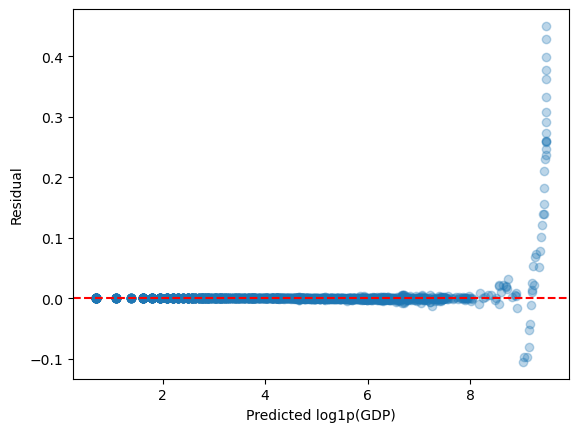

In [41]:
import matplotlib.pyplot as plt
resid = y_te_l - y_pred_rf_l
plt.scatter(y_pred_rf_l, resid, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted log1p(GDP)")
plt.ylabel("Residual")
plt.show()


In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
  'max_depth': [6, 8, 10],
  'min_samples_leaf': [3, 5, 7],
  'max_features': ['sqrt','log2']
}
gs = GridSearchCV(
  rf, param_grid,
  cv=TimeSeriesSplit(3),
  scoring='r2', n_jobs=-1
)
gs.fit(X_a_log, y_log)
print(gs.best_params_, gs.best_score_)


{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7} 0.9782170861892867


In [43]:

# 1) Rebuild & sort your modeling DataFrame, and ensure income_group is present
df_model = updated_final.copy().merge(
    df_clean[['country','year','income_group']],
    on=['country','year'], how='left'
).sort_values(['country','year']).reset_index(drop=True)

# 2) Create log1p‐transformed columns
for col in [
    'GDP_rppp',
    'gov_capital','priv_capital','ppp_capital',
    'labor_force'
]:
    df_model[f'log1p_{col}'] = np.log1p(df_model[col])

# 3) Define your feature set on the log scale + any flags you want to keep
feature_cols = [
    'log1p_gov_capital',
    'log1p_priv_capital',
    'log1p_ppp_capital',
    'log1p_labor_force'
]
# if you have flag columns, you can append them here, e.g.:
flag_cols = [c for c in df_model.columns if c.endswith('_flag')]
feature_cols += flag_cols

X = df_model[feature_cols]
y = df_model['log1p_GDP_rppp']
groups = df_model['income_group'].values

# 4) Instantiate your tuned RandomForest
rf_tuned = RandomForestRegressor(
    n_estimators     = 200,
    max_depth        = 10,
    max_features     = 'sqrt',
    min_samples_leaf = 7,
    random_state     = 42,
    n_jobs           = -1
)

# 5) TimeSeriesSplit CV
tscv = TimeSeriesSplit(n_splits=5)
r2_ts = cross_val_score(rf_tuned, X, y, cv=tscv, scoring='r2', n_jobs=-1)
mse_ts = -cross_val_score(rf_tuned, X, y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
print("Tuned RF (log) TimeSeriesSplit →")
print("  R² :", r2_ts, "→", r2_ts.mean())
print("  MSE:", mse_ts, "→", mse_ts.mean())

# 6) GroupKFold CV by income_group (≤ # groups)
n_splits = min(5, df_model['income_group'].nunique())
gkf = GroupKFold(n_splits=n_splits)

r2_grp = cross_val_score(
    rf_tuned, X, y,
    cv=gkf.split(X, y, groups),
    scoring='r2', n_jobs=-1
)
mse_grp = -cross_val_score(
    rf_tuned, X, y,
    cv=gkf.split(X, y, groups),
    scoring='neg_mean_squared_error', n_jobs=-1
)

print(f"Tuned RF (log) GroupKFold ({n_splits} splits) →")
print("  R² :", r2_grp, "→", r2_grp.mean())
print("  MSE:", mse_grp, "→", mse_grp.mean())


Tuned RF (log) TimeSeriesSplit →
  R² : [0.91852074 0.95946386 0.90302574 0.93881525 0.95635146] → 0.9352354123862648
  MSE: [0.30001272 0.20225761 0.24619241 0.14691186 0.18663652] → 0.21640222421461264
Tuned RF (log) GroupKFold (3 splits) →
  R² : [0.94334675 0.78308231 0.9304159 ] → 0.8856149898549193
  MSE: [0.19065518 0.34183818 0.23512089] → 0.2558714180962956


Top features by RF importance:
log1p_priv_capital     0.410893
log1p_gov_capital      0.338367
log1p_labor_force      0.137457
log1p_ppp_capital      0.039236
patents_res_flag       0.023056
rnd_per_mil_flag       0.018397
patents_nonres_flag    0.011769
energy_pc_flag         0.011455
HCI_flag               0.009370
labor_force_flag       0.000000
dtype: float64 



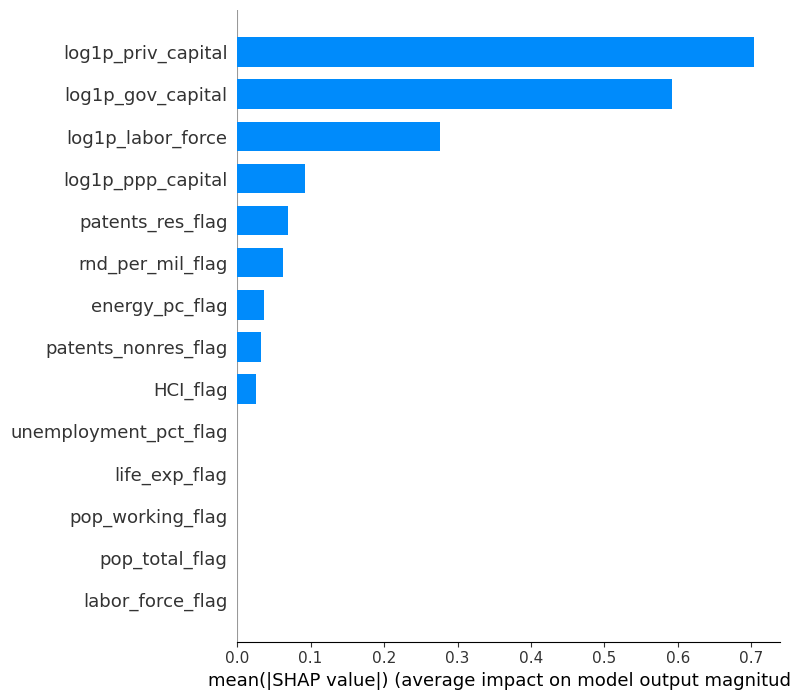

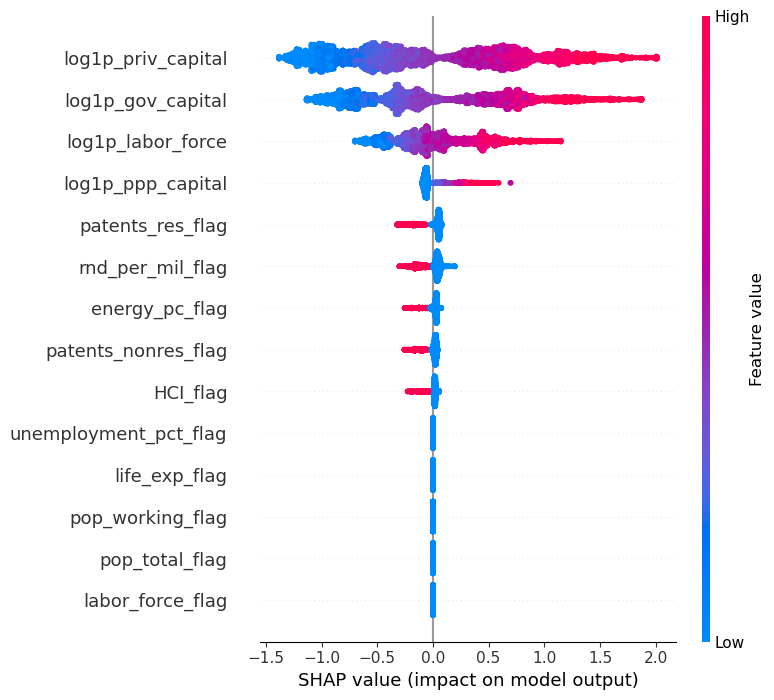

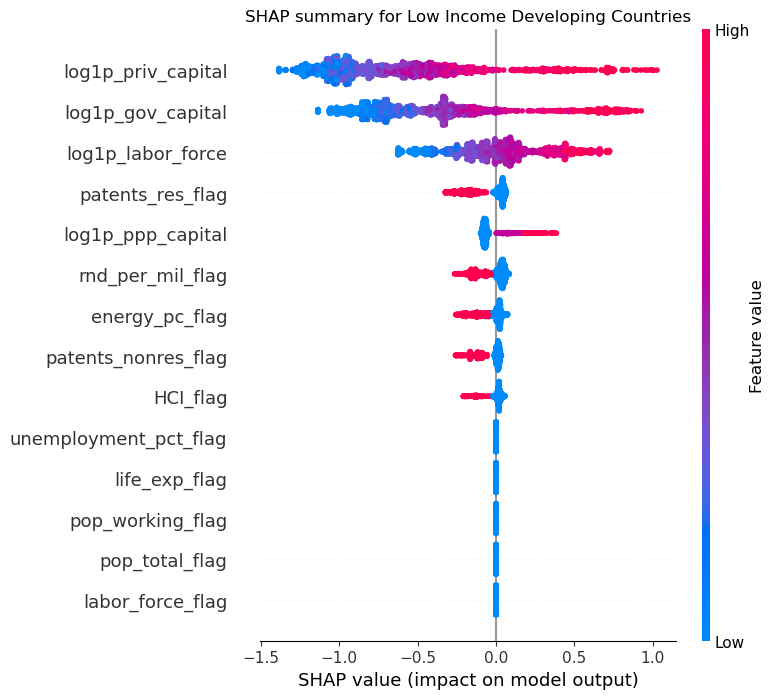

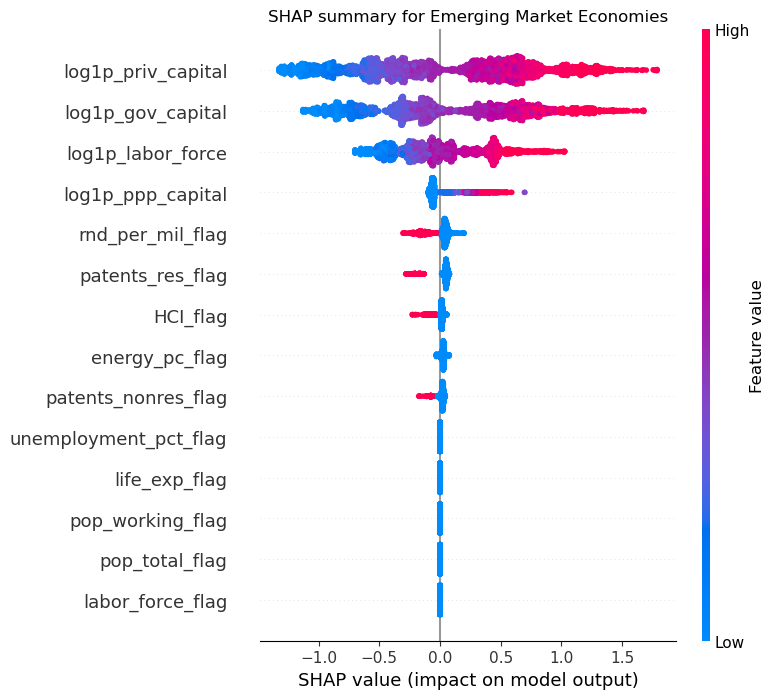

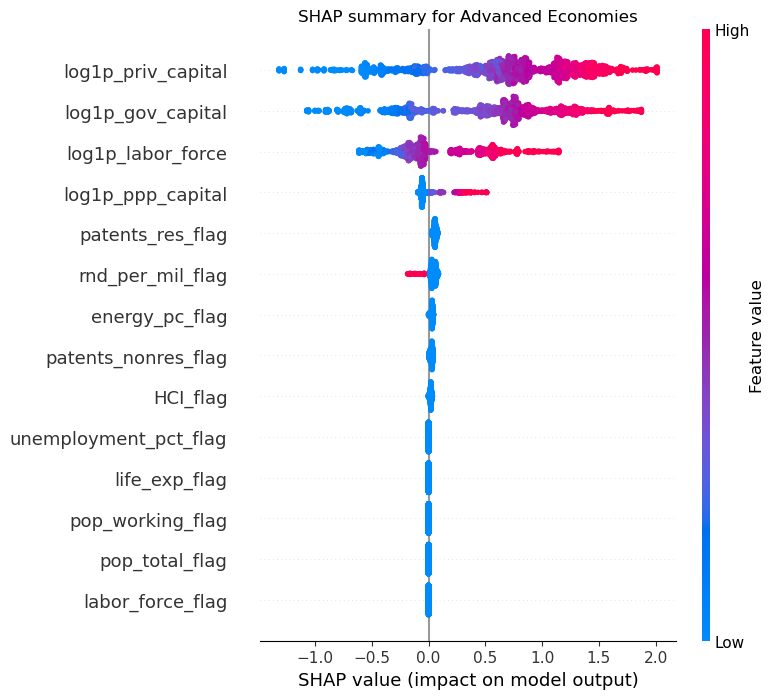

In [44]:
import shap
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 1) Fit your RF on the full log‐panel
rf_model = rf_tuned
rf_model.fit(X, y)

# 2) Plain feature‐importances
importances = (
    pd.Series(rf_model.feature_importances_, index=feature_cols)
      .sort_values(ascending=False)
)
print("Top features by RF importance:")
print(importances.head(10), "\n")

# ─────────────────────────────────────────────────────────────────────────────
# 3) Build SHAP explainer on the fitted RF
explainer = shap.TreeExplainer(rf_model, feature_perturbation="tree_path_dependent")

# 4) Compute SHAP values for every sample
shap_values = explainer.shap_values(X)

# 5) Global bar‐plot of mean(|SHAP|) per feature
shap.summary_plot(shap_values, X, plot_type="bar", show=True)

# 6) Full beeswarm plot (value→effect direction)
shap.summary_plot(shap_values, X, show=True)

# ─────────────────────────────────────────────────────────────────────────────
# 7) Group‐specific SHAP summaries
for grp in df_model['income_group'].unique():
    mask = df_model['income_group'] == grp
    if mask.sum() == 0:
        continue
    plt.title(f"SHAP summary for {grp}")
    shap.summary_plot(
        shap_values[mask.values, :],
        X.loc[mask, :],
        show=True
    )


In [45]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, cross_val_score

# assume X, y, groups already defined on the log1p panel

gb = HistGradientBoostingRegressor(
    max_iter=200,
    max_depth=6,
    learning_rate=0.1,
    max_leaf_nodes=31,
    random_state=42
)

# time‐series CV
tscv = TimeSeriesSplit(n_splits=5)
r2_ts_gb = cross_val_score(gb, X, y, cv=tscv, scoring='r2', n_jobs=-1)
mse_ts_gb = -cross_val_score(gb, X, y, cv=tscv,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1)
print("HistGB TimeSeriesSplit R²:", r2_ts_gb, "→", r2_ts_gb.mean())
print("HistGB TimeSeriesSplit MSE:", mse_ts_gb, "→", mse_ts_gb.mean(), "\n")

# group‐aware CV by income_group
n_splits = min(5, df_model['income_group'].nunique())
gkf = GroupKFold(n_splits=n_splits)

r2_grp_gb = cross_val_score(
    gb, X, y,
    cv=gkf.split(X, y, groups),
    scoring='r2',
    n_jobs=-1
)
mse_grp_gb = -cross_val_score(
    gb, X, y,
    cv=gkf.split(X, y, groups),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
print(f"HistGB GroupKFold ({n_splits} splits) R²:", r2_grp_gb, "→", r2_grp_gb.mean())
print(f"HistGB GroupKFold ({n_splits} splits) MSE:", mse_grp_gb, "→", mse_grp_gb.mean())


HistGB TimeSeriesSplit R²: [0.917293   0.95399056 0.90148916 0.93266757 0.96501502] → 0.9340910651804079
HistGB TimeSeriesSplit MSE: [0.30453333 0.22956699 0.25009338 0.16167318 0.14959205] → 0.2190917871127779 

HistGB GroupKFold (3 splits) R²: [0.92748607 0.73873513 0.966539  ] → 0.8775867361552997
HistGB GroupKFold (3 splits) MSE: [0.24403114 0.41172442 0.11306289] → 0.2562728150340808


In [46]:
# Now train & CV an XGBoost regressor on the same features
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators    = 200,
    max_depth       = 6,
    learning_rate   = 0.1,
    subsample       = 0.8,
    colsample_bytree= 0.8,
    random_state    = 42,
    n_jobs          = -1
)

# time‐series CV
tscv = TimeSeriesSplit(n_splits=5)
r2_ts_xgb = cross_val_score(xgb_model, X, y,
                            cv=tscv, scoring='r2',
                            n_jobs=-1)
mse_ts_xgb = -cross_val_score(xgb_model, X, y,
                              cv=tscv,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)

print("XGB TimeSeriesSplit R²:", r2_ts_xgb, "→", r2_ts_xgb.mean())
print("XGB TimeSeriesSplit MSE:", mse_ts_xgb, "→", mse_ts_xgb.mean(), "\n")

# group‐aware CV by income_group
n_splits = min(5, df_model['income_group'].nunique())
gkf = GroupKFold(n_splits=n_splits)

r2_grp_xgb = cross_val_score(
    xgb_model, X, y,
    cv=gkf.split(X, y, groups),
    scoring='r2',
    n_jobs=-1
)
mse_grp_xgb = -cross_val_score(
    xgb_model, X, y,
    cv=gkf.split(X, y, groups),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

print(f"XGB GroupKFold ({n_splits} splits) R²:", r2_grp_xgb, "→", r2_grp_xgb.mean())
print(f"XGB GroupKFold ({n_splits} splits) MSE:", mse_grp_xgb, "→", mse_grp_xgb.mean())

XGB TimeSeriesSplit R²: [0.90951697 0.95446098 0.90877355 0.92911183 0.96085195] → 0.9325430549001025
XGB TimeSeriesSplit MSE: [0.33316527 0.22721981 0.23160023 0.17021093 0.16739293] → 0.22591783502837873 

XGB GroupKFold (3 splits) R²: [0.93037263 0.7345684  0.96336562] → 0.8761022158172388
XGB GroupKFold (3 splits) MSE: [0.23431701 0.41829073 0.12378557] → 0.25879777091387873


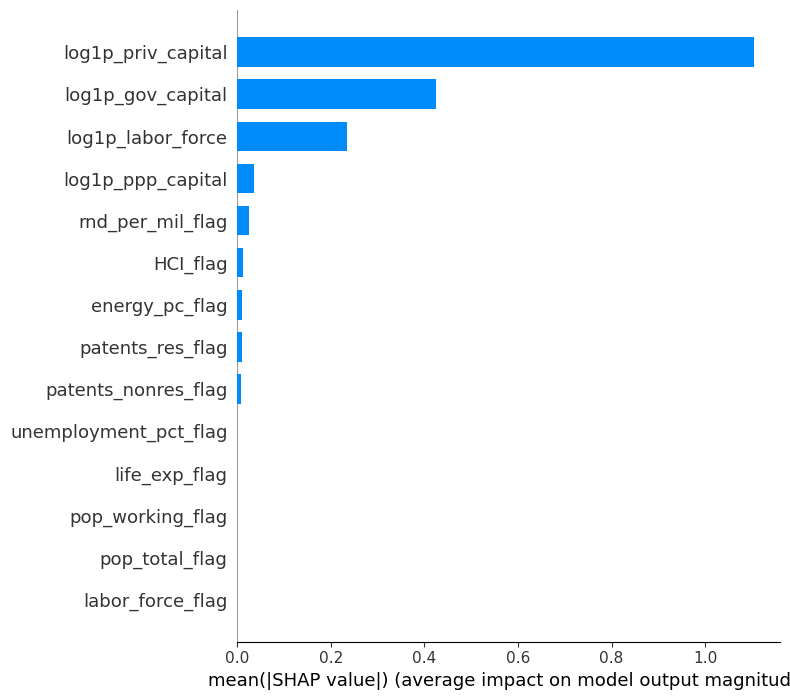

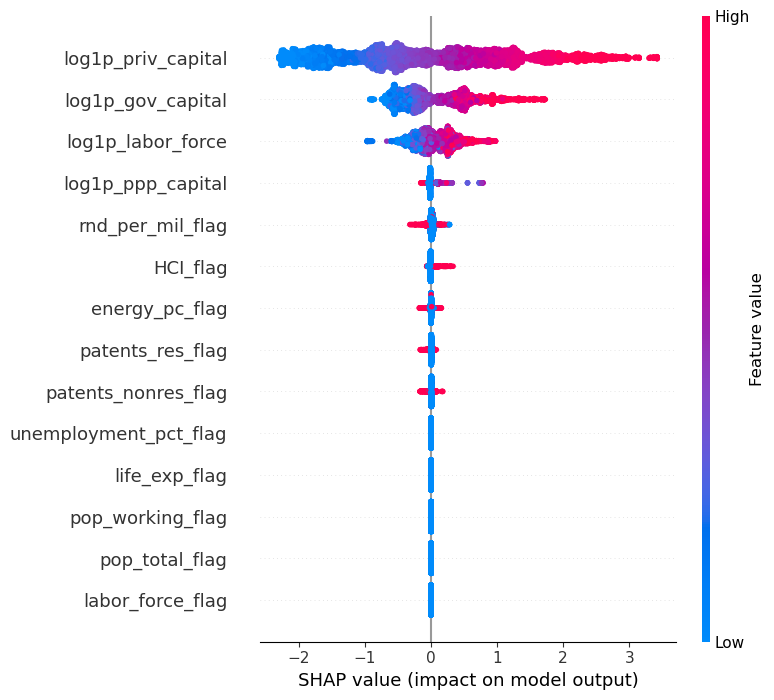

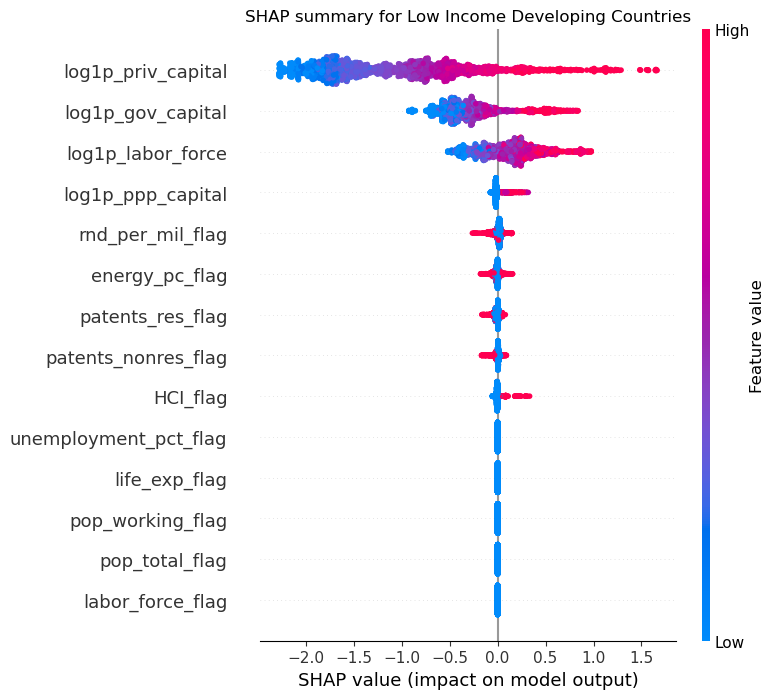

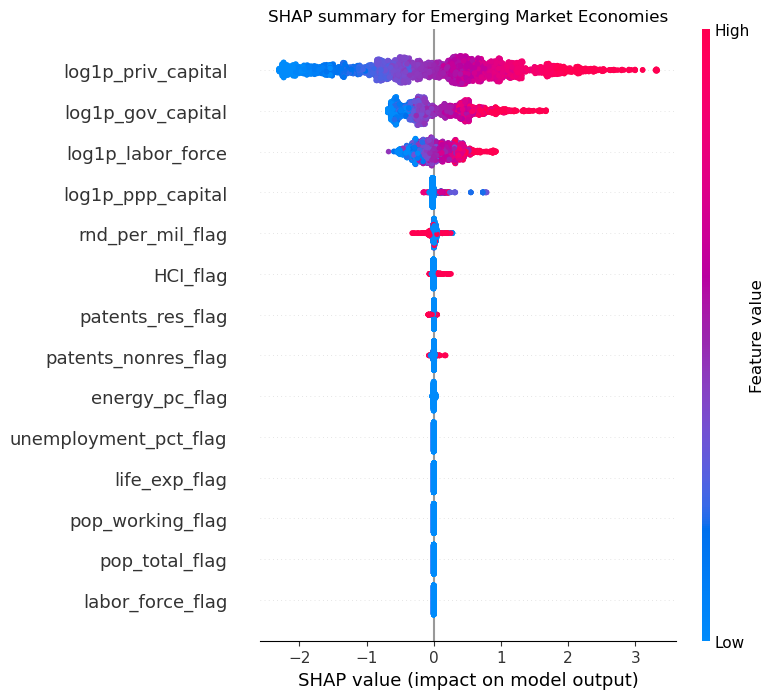

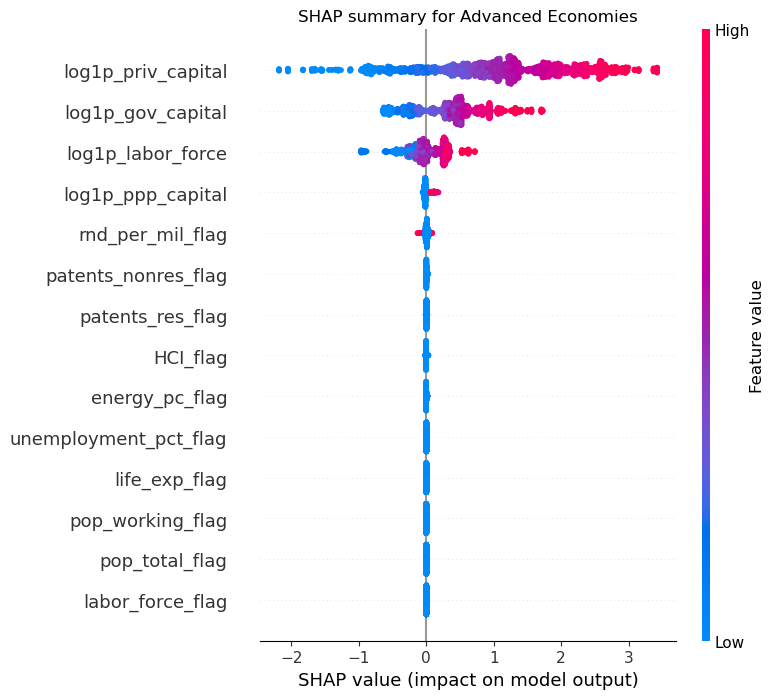

In [47]:
import shap

# 1) Fit your XGBRegressor on the full training set
xgb_model.fit(X, y)

# 2) Create a SHAP TreeExplainer on the fitted model
explainer = shap.TreeExplainer(xgb_model)

# 3) Compute SHAP values for your feature matrix
#    shap_values will have shape (n_samples, n_features)
shap_values = explainer.shap_values(X)

# 4) Global bar‐chart of mean(|SHAP value|) for each feature
shap.summary_plot(
    shap_values, 
    X, 
    plot_type="bar", 
    show=True
)

# 5) Full beeswarm summary, showing distribution and direction
shap.summary_plot(
    shap_values,
    X,
    show=True
)

# 6) SHAP per income_group:
for grp in df_model['income_group'].unique():
    mask = df_model['income_group'] == grp
    plt.title(f"SHAP summary for {grp}")
    shap.summary_plot(
        shap_values[mask], 
        X[mask],
        show=True
    )


In [48]:
from sklearn.ensemble import  VotingRegressor


# 1) Rebuild your modeling frame & sort it
df_model = (
    updated_final
    .merge(
        df_clean[['country','year','income_group']],
        on=['country','year'],
        how='left'
    )
    .sort_values(['country','year'])
    .reset_index(drop=True)
)

# 2) Create log1p columns for both target and predictors
for col in ['GDP_rppp',
            'gov_capital','priv_capital','ppp_capital',
            'pop_total','pop_working','labor_force']:
    df_model[f'log1p_{col}'] = np.log1p(df_model[col])

# 3) Build your feature matrix & target vector
flag_cols = [c for c in df_model.columns if c.endswith('_flag')]

feature_cols = [
    'log1p_gov_capital',
    'log1p_priv_capital',
    'log1p_ppp_capital',
    'log1p_labor_force',
    'log1p_pop_total',
    'log1p_pop_working',
] + flag_cols

X_log = df_model[feature_cols]
y_log = df_model['log1p_GDP_rppp']

# sanity check: must be equal
assert len(X_log) == len(y_log), "X and y must have the same number of rows!"

# 4) Instantiate the two learners and build your VotingRegressor
rf      = RandomForestRegressor(n_estimators=200, max_depth=8,
                                max_features='sqrt', min_samples_leaf=5,
                                random_state=42, n_jobs=-1)
histgb  = HistGradientBoostingRegressor(max_iter=300,
                                        learning_rate=0.05,
                                        random_state=42)

ensemble = VotingRegressor([('rf', rf), ('histgb', histgb)], n_jobs=-1)

# 5) Cross‐validate with a time‐series split
tscv = TimeSeriesSplit(n_splits=5)
r2_ts = cross_val_score(ensemble, X_log, y_log,
                        cv=tscv, scoring='r2', n_jobs=-1)
mse_ts = -cross_val_score(ensemble, X_log, y_log,
                          cv=tscv, scoring='neg_mean_squared_error',
                          n_jobs=-1)

print("VotingRegressor (RF+HistGB) TimeSeriesSplit →")
print("  R² :", np.round(r2_ts, 4), "→", r2_ts.mean())
print("  MSE:", np.round(mse_ts, 4), "→", mse_ts.mean())


VotingRegressor (RF+HistGB) TimeSeriesSplit →
  R² : [0.9332 0.9586 0.9126 0.9465 0.9666] → 0.9434912298813621
  MSE: [0.2461 0.2067 0.2218 0.1285 0.1428] → 0.18918443823883355


In [49]:
from sklearn.metrics import r2_score, mean_squared_error

groups = df_model['income_group'].values
n_splits = min(5, df_model['income_group'].nunique())
gkf     = GroupKFold(n_splits=n_splits)

r2_list     = []
mse_list    = []
group_names = []

for train_idx, test_idx in gkf.split(X_log, y_log, groups):
    # 1) slice rows by position, not by label
    X_train = X_log.iloc[train_idx]
    X_test  = X_log.iloc[test_idx]
    y_train = y_log.iloc[train_idx]
    y_test  = y_log.iloc[test_idx]

    # 2) every test‐fold should contain exactly one income_group
    grp_name = groups[test_idx][0]

    # 3) fit & score
    ensemble.fit(X_train, y_train)
    y_pred = ensemble.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    group_names.append(grp_name)

results_df = pd.DataFrame({
    'income_group': group_names,
    'r2_score'     : r2_list,
    'mse'          : mse_list
})

print(results_df.sort_values('income_group'))



                      income_group  r2_score       mse
2               Advanced Economies  0.948197  0.175040
0        Emerging Market Economies  0.938563  0.206754
1  Low Income Developing Countries  0.705996  0.463318


**Panel Data Analysis on R packages**

In [51]:
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects, compare

# 0) Make sure you have your cleaned final_df in memory
#    It must contain at least: ['GDP_rppp','gov_capital','priv_capital',
#    'ppp_capital','labor_force','country','year']

# 1) Add the log1p columns onto final_df
for col in ['GDP_rppp','gov_capital','priv_capital','ppp_capital','labor_force']:
    final_df[f'log1p_{col}'] = np.log1p(final_df[col])

# 2) Turn it into a proper panel DataFrame
panel_df = (
    final_df
    .set_index(['country','year'])
    .sort_index()
)

# 3) Specify y and X
y = panel_df['log1p_GDP_rppp']
X = panel_df[['log1p_priv_capital',
              'log1p_gov_capital',
              'log1p_ppp_capital',
              'log1p_labor_force']]
X = sm.add_constant(X)

# 4) Fit the Fixed‐Effects (“within”) model
fe = PanelOLS(y, X, entity_effects=True)
fe_res = fe.fit()
print("===== Fixed Effects =====")
print(fe_res)

# 5) Fit the Random‐Effects model
re = RandomEffects(y, X)
re_res = re.fit()
print("\n===== Random Effects =====")
print(re_res)

# 6) Compare via a Hausman‐style test
cmp = compare({'Fixed': fe_res, 'Random': re_res})
print("\n===== Hausman Comparison =====")
print(cmp)



===== Fixed Effects =====
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8693
Estimator:                   PanelOLS   R-squared (Between):              0.9423
No. Observations:                7920   R-squared (Within):               0.8693
Date:                Fri, Apr 25 2025   R-squared (Overall):              0.9453
Time:                        13:22:26   Log-likelihood                    954.20
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.291e+04
Entities:                         149   P-value                           0.0000
Avg Obs:                       53.154   Distribution:                  F(4,7767)
Min Obs:                       22.000                                           
Max Obs:                       60.000   F-statistic (robust):          1.291e+04
  

In [101]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects

# ——————————————————————————————————————————————
# 0) Log-transform the key variables on final_df
for col in ['GDP_rppp', 'gov_capital', 'priv_capital', 'ppp_capital', 'labor_force']:
    final_df[f'log1p_{col}'] = np.log1p(final_df[col])

# 1) Build a proper panel-indexed DataFrame
panel = (
    final_df
    .set_index(['country', 'year'])
    .sort_index()
)

y = panel['log1p_GDP_rppp']
X = sm.add_constant(panel[[
    'log1p_priv_capital',
    'log1p_gov_capital',
    'log1p_ppp_capital',
    'log1p_labor_force'
]])

# ——————————————————————————————————————————————
# 2) Country fixed effects (one-way)
fe_country_res = PanelOLS(y, X, entity_effects=True).fit()

# Extract entity effects
ent = fe_country_res.estimated_effects
country_fe = (
    ent
    .groupby('country')['estimated_effects']
    .mean()
    .reset_index()
    .rename(columns={'estimated_effects': 'country_fixed_effect'})
)

# ——————————————————————————————————————————————
# 3) Year fixed effects (one-way)
fe_time_res = PanelOLS(y, X, time_effects=True).fit()

# Extract time effects
tim = fe_time_res.estimated_effects
time_fe = (
    tim
    .groupby('year')['estimated_effects']
    .mean()
    .reset_index()
    .rename(columns={'estimated_effects': 'time_fixed_effect'})
)

# ——————————————————————————————————————————————
# 4) Random effects (per country)
re_res = RandomEffects(y, X).fit()

# Manual computation of random effects
residuals = re_res.resids

# If residuals is a Series, convert to DataFrame
if isinstance(residuals, pd.Series):
    residuals = residuals.to_frame(name='residuals')
else:
    residuals = residuals.rename(columns={residuals.columns[0]: 'residuals'})

# Compute random effects
country_re = (
    residuals
    .groupby('country')['residuals']
    .mean()
    .reset_index()
    .rename(columns={'residuals': 'country_random_effect'})
)

# Get variance components
sigma2_e = re_res.variance_decomposition['Residual']
sigma2_u = re_res.variance_decomposition['Effects']

# Compute weights
panel_sizes = panel.groupby('country').size()
weight = sigma2_u / (sigma2_u + sigma2_e / panel_sizes)

# Apply weights
country_re['country_random_effect'] = country_re['country_random_effect'] * weight.reindex(country_re['country']).values

# ——————————————————————————————————————————————
# 5) Merge them back onto the original final_df
df_out = (
    final_df
    .merge(country_re, on='country', how='left')
    .merge(country_fe, on='country', how='left')
    .merge(time_fe, on='year', how='left')
)

# 6) Create a DataFrame for country effects (one row per country)
country_effects_df = country_re.merge(country_fe, on='country', how='left')[['country', 'country_random_effect', 'country_fixed_effect']]

# 7) Create a DataFrame for time effects (one row per year)
time_effects_df = time_fe[['year', 'time_fixed_effect']]

# 8) Create a DataFrame with selected columns for full results (for filtering)
result_df = df_out[['country', 'year', 'country_random_effect', 'country_fixed_effect', 'time_fixed_effect']]

# 9) Print the country effects DataFrame
print("\nCountry Effects (Random and Fixed Effects, one row per country):")
display(country_effects_df)

# 10) Print the time effects DataFrame
print("\nTime Effects (Fixed Effects, one row per year, applies to all countries):")
display(time_effects_df)

# 11) Function to print results for a specific country (from full results)
def print_country_results(df, country_name):
    """
    Print results for a specific country.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the results
    country_name (str): Name of the country to filter
    """
    try:
        country_data = df[df['country'] == country_name]
        if country_data.empty:
            print(f"No data found for country: {country_name}")
        else:
            print(f"\nFull Results for {country_name} (including year-specific time effects):")
            print(country_data)
    except KeyError:
        print("Error: 'country' column not found in DataFrame")

# 12) Prompt user to print results for a specific country
country_to_print = input("Enter the country name to print full results (e.g., United States): ")
print_country_results(result_df, country_to_print)

# 13) List available countries
print("\nAvailable countries in the dataset:")
print(result_df['country'].unique())


Country Effects (Random and Fixed Effects, one row per country):


,country,country_random_effect,country_fixed_effect
0,Afghanistan,-0.061641,-0.765484
1,Albania,-0.005106,-0.002000
2,Algeria,-0.020563,-0.285912
3,Angola,-0.058700,-0.729641
4,Argentina,0.023211,0.292720
...,...,...,...
144,United States,-0.009761,-0.247913
145,Uruguay,0.004563,0.119259
146,Uzbekistan,0.079998,0.736363
147,Zambia,0.028321,0.408322



Time Effects (Fixed Effects, one row per year, applies to all countries):


,year,time_fixed_effect
0,1960,-0.291714
1,1961,-0.274729
2,1962,-0.257167
3,1963,-0.226449
4,1964,-0.203562
5,1965,-0.197073
6,1966,-0.198076
7,1967,-0.191634
8,1968,-0.174558
9,1969,-0.146070


Enter the country name to print full results (e.g., United States):  Nepal



Full Results for Nepal (including year-specific time effects):
     country  year  country_random_effect  country_fixed_effect  \
5295   Nepal  1960               0.004632               0.05909   
5296   Nepal  1961               0.004632               0.05909   
5297   Nepal  1962               0.004632               0.05909   
5298   Nepal  1963               0.004632               0.05909   
5299   Nepal  1964               0.004632               0.05909   
5300   Nepal  1965               0.004632               0.05909   
5301   Nepal  1966               0.004632               0.05909   
5302   Nepal  1967               0.004632               0.05909   
5303   Nepal  1968               0.004632               0.05909   
5304   Nepal  1969               0.004632               0.05909   
5305   Nepal  1970               0.004632               0.05909   
5306   Nepal  1971               0.004632               0.05909   
5307   Nepal  1972               0.004632               0.05909  